In [82]:
%matplotlib inline

In [83]:
import numpy as np
import scipy
from scipy import signal
import skimage as sk
import skimage.io as skio
import cv2
import matplotlib.pyplot as plt
import skimage.transform as sktr
import math


1.1: Convolutions from Scratch!

In [232]:
def convolve_4_loops(img, filter):
    filter = filter[::-1, ::-1]
    pad_w = filter.shape[0]//2
    pad_h = filter.shape[1]//2
    img = np.pad(img, pad_width=((pad_w, pad_w), (pad_h, pad_h)), mode='constant', constant_values=0)

    output_r = img.shape[0] - filter.shape[0] + 1
    output_c = img.shape[1] - filter.shape[1] + 1


    output = np.zeros((output_r, output_c))
    for start_r in range(output_r):
        for start_c in range(output_c):
            dot_prod = 0
            for r in range(filter.shape[0]):
                for c in range(filter.shape[1]):
                    dot_prod += filter[r][c] * img[start_r + r][start_c + c]
            output[start_r][start_c] = dot_prod
    return output


def convolve_2_loops(img, filter, pad = 0):
    filter = filter[::-1, ::-1]
    pad_w = filter.shape[0]//2
    pad_h = filter.shape[1]//2
    img = np.pad(img, pad_width=((pad_w, pad_w), (pad_h, pad_h)), mode='constant', constant_values=0)
    
    output_r = img.shape[0] - filter.shape[0] + 1
    output_c = img.shape[1] - filter.shape[1] + 1


    output = np.zeros((output_r, output_c))
    for start_r in range(output_r):
        for start_c in range(output_c):
            dot_prod = np.sum(filter * img[start_r:start_r+filter.shape[0], start_c:start_c+filter.shape[1]])
            output[start_r][start_c] = dot_prod
    return output





In [231]:
# test

img = skio.imread("me.png", as_gray=True)
img = sk.img_as_float(img)


box_filter = np.ones((9, 9), dtype=np.float32) / 81
Dx = np.array([[1, 0, -1]])
Dy = np.array([[1], [0], [-1]])

output_1 = (convolve_4_loops(img, box_filter))
output_1 = (output_1 - output_1.min()) / (output_1.max() - output_1.min())
skio.imsave("me_box_1.png", (output_1 * 255).astype(np.uint8))







In [233]:
output_1 = (convolve_2_loops(img, box_filter, 1))
output_1 = (output_1 - output_1.min()) / (output_1.max() - output_1.min())
skio.imsave("me_box_2.png", (output_1 * 255).astype(np.uint8))


In [234]:
output_1 = (scipy.signal.convolve2d(img, box_filter))
output_1 = (output_1 - output_1.min()) / (output_1.max() - output_1.min())
skio.imsave("me_box_3.png", (output_1 * 255).astype(np.uint8))

In [89]:

Dx_out = (convolve_4_loops(img, Dx, 1))
Dx_out = (Dx_out - Dx_out.min()) / (Dx_out.max() - Dx_out.min())
skio.imsave("me_dx.png", (Dx_out * 255).astype(np.uint8))

Dy_out = (convolve_4_loops(img, Dy, 1))
Dy_out = (Dy_out - Dy_out.min()) / (Dy_out.max() - Dy_out.min())
skio.imsave("me_dy.png", (Dy_out * 255).astype(np.uint8))

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.84370275  0.00392157 -0.00784314 ...  0.          0.00392157
  -0.82745098]
 [ 0.84370275  0.         -0.00392157 ... -0.00392157 -0.01568627
  -0.82801647]
 ...
 [ 0.84679098 -0.00784314  0.         ... -0.04592    -0.01062588
  -0.32425451]
 [ 0.84286941  0.01176471 -0.00392157 ...  0.04311451 -0.01765843
  -0.35562706]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


1.2: Finite Difference Operator

In [238]:
D_x = np.array([[-1, 0, 1]])
D_y = D_x.T

img = skio.imread("cameraman.png", as_gray=True)
img = sk.img_as_float(img)

Dx_out = (scipy.signal.convolve2d(img, D_x, mode='same'))
Dx_out_final = (Dx_out - Dx_out.min()) / (Dx_out.max() - Dx_out.min())
skio.imsave("cameraman_dx.png", (Dx_out_final * 255).astype(np.uint8))

Dy_out = (scipy.signal.convolve2d(img, D_y, mode='same'))
Dy_out_final = (Dy_out - Dy_out.min()) / (Dy_out.max() - Dy_out.min())
skio.imsave("cameraman_dy.png", (Dy_out_final * 255).astype(np.uint8))

# gradient = np.sqrt(Dx_out * Dx_out + Dy_out * Dy_out)
gradient = np.sqrt(Dx_out**2 + Dy_out**2)
gradient = np.clip(gradient, 0, 1)
gradient = (gradient * 255).astype(np.uint8)
print(gradient)
skio.imsave("cameraman_gradient.png", gradient)

T = 72
edge_img = ((gradient > T)*255).astype(np.uint8)
skio.imsave("cameraman_edges.png", edge_img)

[[255 255 255 ... 255 255 255]
 [255   0   0 ...   0   0 255]
 [255   0   0 ...   0   0 255]
 ...
 [121 134   5 ...   0   0 255]
 [121 189 134 ...   0   0 255]
 [255 121 121 ... 255 255 255]]


1.3 Derivative of Gaussian (DoG) Filter

In [236]:
#Convolve blurred with Dx and Dy
blurred = scipy.signal.correlate2d(img, G2D, mode='same', boundary='symm')
blurred_final = (np.clip(blurred / (blurred.max()), 0, 1) * 255).astype(np.uint8)
skio.imsave("cameraman_blurred.png", blurred_final)

Ix_b = scipy.signal.correlate2d(blurred, Dx, mode='same', boundary='symm')
Iy_b = scipy.signal.correlate2d(blurred, Dy, mode='same', boundary='symm')

combined = np.sqrt(Ix_b**2 + Iy_b**2)
combined_final = (np.clip(combined / (combined.max()), 0, 1) * 255).astype(np.uint8)
skio.imsave("cameraman_new_gradient_1.png", combined_final)

edge_b = ((combined_final > T)*255).astype(np.uint8)
skio.imsave("cameraman_new_edges_1.png", edge_b)


In [102]:
# Convolve Gaussian with Dx and Dy
img = img.astype(np.float32)  

sigma = 1.2
k = int(2*np.ceil(3*sigma)+1)
g1d = cv2.getGaussianKernel(ksize, sigma).astype(np.float32)
G2D = g1d @ g1d.T

Dx = np.array([[-1, 0, 1]], dtype=np.float32)
Dy = Dx.T

Gx = scipy.signal.correlate2d(G2D, Dx, mode='same', boundary='symm')
Gy = scipy.signal.correlate2d(G2D, Dy, mode='same', boundary='symm')

Ix = scipy.signal.correlate2d(img, Gx, mode='same', boundary='symm')
Iy = scipy.signal.correlate2d(img, Gy, mode='same', boundary='symm')

combined = np.sqrt(Ix**2 + Iy**2)
combined_final = (np.clip(combined / (combined.max()), 0, 1) * 255).astype(np.uint8)
skio.imsave("cameraman_new_gradient_2.png", combined_final)

T = 72
edge_img = ((combined_final > T)*255).astype(np.uint8)
skio.imsave("cameraman_new_edges_2.png", edge_img)


Part 2.1: Image "Sharpening"

In [249]:
def resharpen(img_name):
    img = skio.imread(f"{img_name}.jpg")
    img = sk.img_as_float(img)

    sigma = 2
    k = int(2*np.ceil(3*sigma)+1)
    g1d = cv2.getGaussianKernel(ksize, sigma).astype(np.float32)
    G2D = g1d @ g1d.T

    Dx = np.array([[-1, 0, 1]])
    Dy = Dx.T

    Dx_out = scipy.signal.convolve2d(G2D, Dx, mode='same')
    Dy_out = scipy.signal.convolve2d(G2D, Dy, mode='same')

    gaussian_grad = np.sqrt(Dx_out ** 2 + Dy_out ** 2)

    blurred = np.dstack([scipy.signal.convolve2d(img[:, :, 0], gaussian_grad, mode='same'), scipy.signal.convolve2d(img[:, :, 1], gaussian_grad, mode='same'), scipy.signal.convolve2d(img[:, :, 2], gaussian_grad, mode='same')])
    blurred_final = np.clip(blurred, 0, 1)
    blurred_final = (blurred_final * 255).astype(np.uint8)
    skio.imsave(f"{img_name}_blurred.png", blurred_final)

    high_freqs = img - blurred
    high_freqs_final = (high_freqs - high_freqs.min()) / (high_freqs.max() - high_freqs.min())
    skio.imsave(f"{img_name}_high_freqs.png", (high_freqs_final * 255).astype(np.uint8))

    alpha = 1
    boosted = img + alpha * high_freqs
    boosted_final = np.clip(boosted, 0, 1)
    boosted_final = (boosted_final * 255).astype(np.uint8)
    skio.imsave(f"{img_name}_boosted.png", boosted_final)

    #re-sharpening the blurred image
    new_alpha = 1
    resharpened = blurred + new_alpha * high_freqs
    resharpened_final = np.clip(resharpened, 0, 1)
    resharpened_final = (resharpened_final * 255).astype(np.uint8)
    skio.imsave(f"{img_name}_resharpened.png", resharpened_final)

resharpen("taj")
resharpen("eiffel")

In [ ]:
2.2 

In [130]:
def get_points(pts):
    # print('Please select 2 points in each image for alignment.')
    # plt.imshow(im1)
    # p1, p2 = plt.ginput(2)
    # plt.close()
    # plt.imshow(im2)
    # p3, p4 = plt.ginput(2)
    # plt.close()
    return (pts[0], pts[1], pts[2], pts[3])

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale)
    else:
        im2 = sktr.rescale(im2, 1./dscale)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2, pts):
    pts = get_points(pts)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

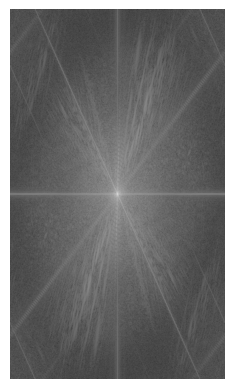

In [262]:
cat_img = skio.imread("hybrid_python/nutmeg.jpg", as_gray=True)
cat_img = sk.img_as_float(cat_img)
cat_img = np.expand_dims(cat_img, axis=2)

derek_img = skio.imread("hybrid_python/DerekPicture.jpg", as_gray=True)
derek_img = sk.img_as_float(derek_img)
derek_img = np.expand_dims(derek_img, axis=2)

cat_img, derek_img = align_images(cat_img, derek_img, [(612, 286), (759, 373), (296, 350), (446, 332)])
cat_aligned = np.clip(cat_img, 0, 1)
cat_aligned = (cat_aligned * 255).astype(np.uint8)
skio.imsave("cat_aligned.png", cat_aligned.squeeze(-1))
derek_aligned = np.clip(derek_img, 0, 1)
derek_aligned = (derek_aligned * 255).astype(np.uint8)
skio.imsave("derek_aligned.png", derek_aligned.squeeze(-1))
#plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(cat_aligned.squeeze(-1))))))

sigma = 10
k = int(2*np.ceil(3*sigma)+1)
g1d = cv2.getGaussianKernel(ksize, sigma).astype(np.float32)
G2D = g1d @ g1d.T

Dx = np.array([[-1, 0, 1]])
Dy = Dx.T

Dx_out = scipy.signal.convolve2d(G2D, Dx, mode='same')
Dy_out = scipy.signal.convolve2d(G2D, Dy, mode='same')

gaussian_grad = np.sqrt(Dx_out ** 2 + Dy_out ** 2)

low_pass_cat = scipy.signal.convolve2d(cat_img[:, :, 0], gaussian_grad, mode='same')
low_pass_cat = np.expand_dims(low_pass_cat, axis=2)
low_pass_cat_final = np.clip(low_pass_cat, 0, 1)
low_pass_cat_final = (low_pass_cat_final * 255).astype(np.uint8)
skio.imsave("low_pass_cat.png", low_pass_cat_final.squeeze(-1))
high_pass_cat = cat_img - low_pass_cat
high_pass_cat_final = np.clip(high_pass_cat, 0, 1)
high_pass_cat_final = (high_pass_cat_final * 255).astype(np.uint8)
skio.imsave("high_pass_cat.png", high_pass_cat_final.squeeze(-1))

low_pass_derek = scipy.signal.convolve2d(derek_img[:, :, 0], gaussian_grad, mode='same')
low_pass_derek = np.expand_dims(low_pass_derek, axis=2)
low_pass_derek_final = np.clip(low_pass_derek, 0, 1)
low_pass_derek_final = (low_pass_derek_final * 255).astype(np.uint8)
skio.imsave("low_pass_derek.png", low_pass_derek_final.squeeze(-1))

final_img = (low_pass_derek + high_pass_cat)/2.0
final_img = np.clip(final_img, 0, 1)
final_img = (final_img * 255).astype(np.uint8)
skio.imsave("derek_x_nutmeg.png", final_img.squeeze(-1))



In [183]:
img_1 = skio.imread("rory.png", as_gray=True)
img_1 = sk.img_as_float(img_1)
img_1 = np.expand_dims(img_1, axis=2)

img_2 = skio.imread("lorelai.png", as_gray=True)
img_2 = sk.img_as_float(img_2)
img_2 = np.expand_dims(img_2, axis=2)

img_2, img_1 = align_images(img_2, img_1, [(202, 106), (258, 110), (218, 123), (266, 129)])

sigma = 3
k = int(2*np.ceil(3*sigma)+1)
g1d = cv2.getGaussianKernel(ksize, sigma).astype(np.float32)
G2D = g1d @ g1d.T

Dx = np.array([[-1, 0, 1]])
Dy = Dx.T

Dx_out = scipy.signal.convolve2d(G2D, Dx, mode='same')
Dy_out = scipy.signal.convolve2d(G2D, Dy, mode='same')

gaussian_grad = np.sqrt(Dx_out ** 2 + Dy_out ** 2)

low_pass_img_1 = scipy.signal.convolve2d(img_1[:, :, 0], gaussian_grad, mode='same')
low_pass_img_1 = np.expand_dims(low_pass_img_1, axis=2)
low_pass_img_1_final = np.clip(low_pass_img_1, 0, 1)
low_pass_img_1_final = (low_pass_img_1_final * 255).astype(np.uint8)
skio.imsave("low_pass_rory.png", low_pass_img_1_final.squeeze(-1))
high_pass_img_1 = img_1 - low_pass_img_1
high_pass_img_1_final = np.clip(high_pass_img_1, 0, 1)
high_pass_img_1_final = (high_pass_img_1_final * 255).astype(np.uint8)
skio.imsave("high_pass_rory.png", high_pass_img_1_final.squeeze(-1))

low_pass_img_2 = scipy.signal.convolve2d(img_2[:, :, 0], gaussian_grad, mode='same')
low_pass_img_2 = np.expand_dims(low_pass_img_2, axis=2)
low_pass_img_2_final = np.clip(low_pass_img_2, 0, 1)
low_pass_img_2_final = (low_pass_img_2_final * 255).astype(np.uint8)
skio.imsave("low_pass_lorelai.png", low_pass_img_2_final.squeeze(-1))

final_img = (low_pass_img_2 + high_pass_img_1)/2.0
final_img = np.clip(final_img, 0, 1)
final_img = (final_img * 255).astype(np.uint8)
skio.imsave("roryxlor.png", final_img.squeeze(-1))



In [219]:
img_1 = skio.imread("merlin.png", as_gray=True)
img_1 = sk.img_as_float(img_1)
img_1 = np.expand_dims(img_1, axis=2)

img_2 = skio.imread("pandy.png", as_gray=True)
img_2 = sk.img_as_float(img_2)
img_2 = np.expand_dims(img_2, axis=2)

img_2, img_1 = align_images(img_2, img_1, [(322, 595), (500, 588), (414, 601), (610, 597)])

sigma = 3
k = int(2*np.ceil(3*sigma)+1)
g1d = cv2.getGaussianKernel(ksize, sigma).astype(np.float32)
G2D = g1d @ g1d.T

Dx = np.array([[-1, 0, 1]])
Dy = Dx.T

Dx_out = scipy.signal.convolve2d(G2D, Dx, mode='same')
Dy_out = scipy.signal.convolve2d(G2D, Dy, mode='same')

gaussian_grad = np.sqrt(Dx_out ** 2 + Dy_out ** 2)

low_pass_img_1 = scipy.signal.convolve2d(img_1[:, :, 0], gaussian_grad, mode='same')
low_pass_img_1 = np.expand_dims(low_pass_img_1, axis=2)
low_pass_img_1_final = np.clip(low_pass_img_1, 0, 1)
low_pass_img_1_final = (low_pass_img_1_final * 255).astype(np.uint8)
skio.imsave("low_pass_merlin.png", low_pass_img_1_final.squeeze(-1))
high_pass_img_1 = img_1 - low_pass_img_1
high_pass_img_1_final = np.clip(high_pass_img_1, 0, 1)
high_pass_img_1_final = (high_pass_img_1_final * 255).astype(np.uint8)
skio.imsave("high_pass_merlin.png", high_pass_img_1_final.squeeze(-1))

low_pass_img_2 = scipy.signal.convolve2d(img_2[:, :, 0], gaussian_grad, mode='same')
low_pass_img_2 = np.expand_dims(low_pass_img_2, axis=2)
low_pass_img_2_final = np.clip(low_pass_img_2, 0, 1)
low_pass_img_2_final = (low_pass_img_2_final * 255).astype(np.uint8)
skio.imsave("low_pass_pandy.png", low_pass_img_2_final.squeeze(-1))

final_img = (low_pass_img_2 + high_pass_img_1)/2.0
final_img = np.clip(final_img, 0, 1)
final_img = (final_img * 255).astype(np.uint8)
skio.imsave("merlinxpandy.png", final_img.squeeze(-1))

Part 2.3: Gaussian and Laplacian Stacks

In [78]:
# Gaussian Stack
def gaussian(img, sigma):
    ksize = int(2 * np.ceil(3 * sigma) + 1)
    return cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

def gaussian_stack(img, levels=6, sigma0=2, k=np.sqrt(2.0)):
    iimg = img.astype(np.float32)
    if img.max() > 1.5:
        img = img / 255.0
    stack, sigmas = [img.copy()], [0.0]
    for ell in range(1, levels):
        s = sigma0 * (k ** ell)
        gauss = gaussian(img, s)
        stack.append(gauss)
        sigmas.append(s)
        # gauss = np.clip(gauss, 0, 1)
        # gauss = (gauss * 255).astype(np.uint8)
        # skio.imsave(f"gaussian_stack_{ell}.png", gauss)
    return stack

def laplacian_stack_from_gaussian(gauss_stack):
    L = []
    for i in range(len(gauss_stack) - 1):
        laplac = gauss_stack[i] - gauss_stack[i + 1]
        L.append(laplac)
        m = np.max(np.abs(laplac))
        lap_vis = 0.5 + 0.5 * (laplac / (m + 1e-8))   
        skio.imsave(f"laplacian_stack_{i}.png", (np.clip(lap_vis, 0, 1) * 255).astype(np.uint8))
    L.append(gauss_stack[-1])
    g_last = gauss_stack[-1]
    g_last_vis = (g_last - g_last.min()) / (g_last.max() - g_last.min())
    skio.imsave(f"laplacian_stack_last.png", (g_last_vis * 255).astype(np.uint8))
    return L


apple_img = skio.imread("apple.jpeg")
GA = gaussian_stack(apple_img)
LA = laplacian_stack_from_gaussian(GA)


H, W = img.shape[:2]           
mask = np.zeros((H, W), dtype=np.float32)
mask[:, :W//2] = 1.0
M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

GM = gaussian_stack(M)
apple_layers = []
for i in range(6):
    blended = GM[i] * LA[i]
    apple_layers.append(blended)
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    skio.imsave(f"apple_mask_{i+1}.png", (blended * 255).astype(np.uint8))

orange_img = skio.imread("orange.jpeg")
GB = gaussian_stack(orange_img)
LB = laplacian_stack_from_gaussian(GB)


H, W = img.shape[:2]           
mask = np.zeros((H, W), dtype=np.float32)
mask[:, :W//2] = 1.0
M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

GM = gaussian_stack(M)
orange_layers = []
for i in range(6):
    blended = (1-GM[i]) * LB[i]
    orange_layers.append(blended)
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    skio.imsave(f"orange_mask_{i+1}.png", (blended * 255).astype(np.uint8))

M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

L_blend = [(GM[i] * LA[i]) + ((1.0 - GM[i]) * LB[i]) for i in range(6)]
for i in range(6):
    blended = L_blend[i]
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    skio.imsave(f"blended_mask_{i+1}.png", (blended * 255).astype(np.uint8))
out = np.clip(sum(L_blend), 0.0, 1.0)
skio.imsave(f"oraple.png", (out * 255).astype(np.uint8))

In [217]:
lion_img = skio.imread("space.jpg")[:, :, 0:3]
GA = gaussian_stack(lion_img)
LA = laplacian_stack_from_gaussian(GA)


H, W = lion_img.shape[:2]           
mask = np.zeros((H, W), dtype=np.float32)
mask[:H//2-54, :] = 1.0
M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

GM = gaussian_stack(M)
lion_layers = []
for i in range(6):
    blended = GM[i] * LA[i]
    lion_layers.append(blended)
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    #skio.imsave(f"lion_mask_{i+1}.png", (blended * 255).astype(np.uint8))

tiger_img = skio.imread("beach.jpg")[:, :, 0:3]
GB = gaussian_stack(tiger_img)
LB = laplacian_stack_from_gaussian(GB)



GM = gaussian_stack(M)
tiger_layers = []
for i in range(6):
    blended = (1-GM[i]) * LB[i]
    tiger_layers.append(blended)
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    #skio.imsave(f"orange_mask_{i+1}.png", (blended * 255).astype(np.uint8))

M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

L_blend = [(GM[i] * LA[i]) + ((1.0 - GM[i]) * LB[i]) for i in range(6)]
for i in range(6):
    blended = L_blend[i]
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    #skio.imsave(f"blended_mask_{i+1}.png", (blended * 255).astype(np.uint8))
out = np.clip(sum(L_blend), 0.0, 1.0)
skio.imsave(f"spacexbeach.png", (out * 255).astype(np.uint8))

In [222]:
lion_img = skio.imread("hand.png")[:, :, 0:3]
GA = gaussian_stack(lion_img)
LA = laplacian_stack_from_gaussian(GA)


H, W = lion_img.shape[:2]           
mask = skio.imread("eye_mask.png", as_gray = True)
M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

GM = gaussian_stack(M)
lion_layers = []
for i in range(6):
    blended = GM[i] * LA[i]
    lion_layers.append(blended)
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    #skio.imsave(f"lion_mask_{i+1}.png", (blended * 255).astype(np.uint8))

tiger_img = skio.imread("eye.png")[:, :, 0:3]
GB = gaussian_stack(tiger_img)
LB = laplacian_stack_from_gaussian(GB)



GM = gaussian_stack(M)
tiger_layers = []
for i in range(6):
    blended = (1-GM[i]) * LB[i]
    tiger_layers.append(blended)
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    #skio.imsave(f"orange_mask_{i+1}.png", (blended * 255).astype(np.uint8))

M = mask.astype(np.float32)
if M.ndim == 2:
    M = M[..., None]
if M.shape[2] == 1 and A.shape[2] == 3:
    M = np.repeat(M, 3, axis=2)

L_blend = [((1.0 - GM[i]) * LA[i]) + ((GM[i]) * LB[i]) for i in range(6)]
for i in range(6):
    blended = L_blend[i]
    blended = (blended - blended.min()) / (blended.max() - blended.min())
    #skio.imsave(f"blended_mask_{i+1}.png", (blended * 255).astype(np.uint8))
out = np.clip(sum(L_blend), 0.0, 1.0)
skio.imsave(f"eye_on_hand.png", (out * 255).astype(np.uint8))